In [1]:
import numpy as np
s = None

labels = []
datas = None

for line in open('/content/sample_data/mnist_test.csv', 'r'):
    a = list(map(int,line.split(',')))
    label = a[0]
    labels.append(label)
    data = np.array(a[1:]).reshape((1,28,28))
    if datas is None:
      datas = data
    else:
      datas = np.vstack((datas,data))
    if datas.shape[0] > 100:
      break

print(datas.shape)
print(len(labels))

(101, 28, 28)
101


In [2]:
import torch

class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, transform = None):
        self.transform = transform

        import numpy as np
        labels = []
        datas = None

        for line in open('/content/sample_data/mnist_test.csv', 'r'):
            a = list(map(int,line.split(',')))
            label = a[0]
            labels.append(label)
            data = np.array(a[1:],dtype = np.uint8).reshape((1,28,28))
            if datas is None:
              datas = data
            else:
              datas = np.vstack((datas,data))
            if datas.shape[0] > 10000:
              break

        self.data = datas
        self.label =  labels

        self.datanum = len(labels)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.label[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [3]:
import torchvision

trans = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor()
                                        ])

dataset = Mydatasets(trans)

trainloader = torch.utils.data.DataLoader(dataset, batch_size = 100, shuffle = True, num_workers = 2)

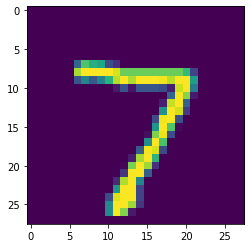

In [5]:
from matplotlib import pyplot as plt

img = dataset[0][0].unsqueeze(dim = 0)
plt.imshow(img.squeeze().detach().numpy())

In [6]:
img.shape

torch.Size([1, 1, 28, 28])

In [259]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class GAN_discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(64 * 24 * 24, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = x.view(-1, 64 * 24 * 24)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = torch.sigmoid(x)
    x = torch.clamp(x,min = 0.02, max = 0.98)
    return x

class GAN_generator(nn.Module):
  def __init__(self, output_shape=(1, 28, 28)):
    super().__init__()
    
    self.fc1 = nn.Linear(10, 30)
    self.fc2 = nn.Linear(30, 90)
    self.fc3 = nn.Linear(90, 270)
    self.fc4 = nn.Linear(270, 784)
    self.conv1 = nn.Conv2d(1,1,3,1,1)
    self.output_shape = output_shape

  def forward(self, num):
    z = torch.randn(num, 10)
    x = self.fc1(z)
    x = F.leaky_relu(x)
    x = self.fc2(x)
    x = F.leaky_relu(x)
    x = self.fc3(x)
    x = F.leaky_relu(x)
    x = self.fc4(x)
    x = F.leaky_relu(x)
    x = x.view(-1, *(self.output_shape))
    x = self.conv1(x)
    x = torch.sigmoid(x)
    return x


disc = GAN_discriminator()
disc_optimizer = optim.Adam(disc.parameters(), lr=0.0005, weight_decay=0.1)

gene = GAN_generator()
gene_optimizer = optim.Adam(gene.parameters(), lr=0.0005, weight_decay=0.1)

In [260]:
loss_func = torch.nn.BCELoss()

In [ ]:
from tqdm.notebook import tqdm
import numpy as np


disc_loss = 1
gene_loss = 1

with tqdm(range(100)) as pbar:
  for i in pbar:
    disc_epoch_loss = []
    gene_epoch_loss = []
    for x, label in trainloader:
      batch_size = x.shape[0]
      falses = torch.zeros(batch_size, 1)
      trues = torch.ones(batch_size, 1)

      temp = np.random.choice([0.0,1.0], batch_size,  p=[0.1, 0.9])
      f_trues = torch.tensor(temp, dtype=torch.float).unsqueeze(dim = 1)

      temp = np.random.choice([0.0,1.0], batch_size,  p=[0.9, 0.1])
      f_falses = torch.tensor(temp, dtype=torch.float).unsqueeze(dim = 1) # contain deception
      
      gene.requires_grad_(False)
      disc.requires_grad_(True)

      fakes = gene(batch_size)

      gene_optimizer.zero_grad()
      disc_optimizer.zero_grad()
      
      
      loss = (
          loss_func(disc(x), f_trues)  + loss_func(disc(fakes),  f_falses)
          ) / 2
      temp = loss
      temp.backward()
      disc_optimizer.step()
      disc_loss = float(loss)


      gene.requires_grad_(True)
      disc.requires_grad_(False)

      fakes = gene(batch_size)

      gene_optimizer.zero_grad()
      disc_optimizer.zero_grad()

      loss = loss_func(disc(fakes), trues)
      temp = loss
      temp.backward()
      gene_optimizer.step()
      gene_loss = float(loss)




      pbar.postfix = 'disc_loss = {}, gene_loss = {}'.format(disc_loss, gene_loss)
      pbar.refresh()
      disc_epoch_loss.append(disc_loss)
      gene_epoch_loss.append(gene_loss)

In [272]:
print(disc(x).mean())
print(disc(fakes).mean())

tensor(0.8514)
tensor(0.0773, grad_fn=<MeanBackward0>)


In [ ]:
img = dataset[200][0].unsqueeze(dim = 0)

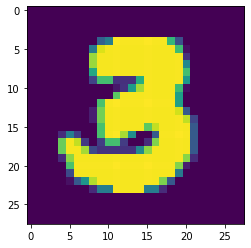

In [ ]:
plt.imshow(img.squeeze().detach().numpy());

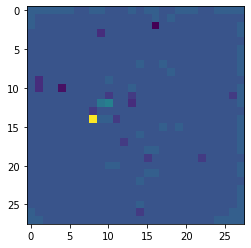

In [277]:
plt.imshow(gene(1).squeeze().detach().numpy())